### Classification models
##### Without Departure Delay Column, balanced and with PCA

In [1]:
import numpy as np
import pandas as pd

import warnings
warnings.simplefilter('ignore')

from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn import metrics
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from sklearn.linear_model import LogisticRegression, LinearRegression

from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score, classification_report

import xgboost as xgb

##### Load the SQL db for later comparison

In [2]:
import sqlite3
conn=sqlite3.connect("models.db")
cur=conn.cursor()

In [4]:
#Loading the dataset
df=pd.read_csv('depdelay20enc.csv', index_col=False, warn_bad_lines=True, error_bad_lines=False)
df=df.drop(['Unnamed: 0','DepDelay'],axis=1)
df = df.sample(frac =.02).reset_index().drop(['index'], axis=1)
df.head()

,CRSElapsedTime,Distance,ArrDelay,DepTime_sin,DepTime_cos,ArrTime_sin,ArrTime_cos,Month_sin,Month_cos,DayOfWeek_sin,DayOfWeek_cos,origin_freq,dest_freq,carrier
0,0.278278,-0.380734,0,-0.598325,-0.801254,-0.794944,-0.606682,1.000000,6.123234e-17,0.781831,0.623490,0.000485,0.055796,0.042186
1,0.975309,2.409786,1,-0.927836,-0.372988,-0.939094,0.343660,0.866025,-5.000000e-01,0.781831,0.623490,0.068270,0.016548,0.059441
2,0.208709,-0.513761,1,-0.370557,-0.928810,-0.623197,-0.782065,-1.000000,-1.836970e-16,0.781831,0.623490,0.004281,0.055796,0.059441
3,0.342342,-0.480122,1,-0.962455,0.271440,-0.834367,0.551209,1.000000,6.123234e-17,0.000000,1.000000,0.002323,0.019771,0.027531
4,0.457457,0.126911,1,-0.856718,0.515786,-0.243615,0.969872,0.500000,8.660254e-01,0.974928,-0.222521,0.015944,0.015046,0.195616


##### Split Train and Test  and set ArrDelay as target column

In [5]:
X,y = df.loc[:, df.columns != 'ArrDelay'],df.loc[:, df.columns == 'ArrDelay']

X_train,X_test, y_train, y_test = train_test_split(X,y, test_size=0.25, random_state=42, stratify=y)

##### Apply PCA

In [6]:
from sklearn.decomposition import PCA
pca = PCA(n_components=3)
principalComponents = pca.fit_transform(X)
principalDf = pd.DataFrame(data = principalComponents, columns = ['component_1', 'component_2', 'component_3'])

In [6]:
principalDf

,component_1,component_2,component_3
0,1.126088,-0.720947,-0.914716
1,-1.026933,0.893241,0.720963
2,1.171402,-0.112925,0.733394
3,1.344861,0.102220,0.455604
4,0.059360,0.328877,0.810598
...,...,...,...
7708,-0.088579,0.307509,0.443416
7709,-0.278303,-0.844049,0.759292
7710,1.138404,1.227541,1.064855
7711,1.101782,-0.976768,0.396171


In [7]:
df = pd.concat([principalDf, df[['ArrDelay']]], axis = 1)

##### The target classes are imbalanced, it can be balanced undersampling the majority class (1)

In [8]:
from sklearn.utils import resample

# concatenate our training data back together
X = pd.concat([X_train, y_train], axis=1)


# Separate majority and minority classes
df_majority = X[X.ArrDelay==1]
df_minority = X[X.ArrDelay==0]

print('majority-1',len(df_majority),'minority-0',len(df_minority))

# Downsample majority class
df_majority_downsampled = resample(df_majority, 
                                 replace=False,    # sample without replacement
                                 n_samples=len(df_minority),     # to match minority class
                                 random_state=42) # reproducible results
 
# Combine minority class with downsampled majority class
downsampled = pd.concat([df_majority_downsampled, df_minority])
 
# Display new class counts
downsampled['ArrDelay'].value_counts()

majority-1 3765 minority-0 2019


0    2019
1    2019
Name: ArrDelay, dtype: int64

In [9]:
y_train = downsampled.ArrDelay
X_train = downsampled.drop('ArrDelay', axis=1)

##### Support Vector Classification

In [10]:
clf = svm.SVC(kernel='linear', random_state=42, gamma='auto')
scores = cross_val_score(clf, X_train, y_train, cv=StratifiedKFold(n_splits=5), scoring='accuracy').mean()
print('Accuracy Score: %.4f' % scores)

Accuracy Score: 0.5856


In [11]:
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)


In [12]:
cm=confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

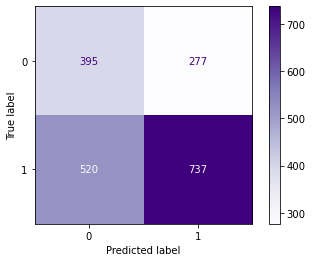

In [13]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=clf.classes_)
disp.plot(cmap='Purples') 

In [14]:
#Specificity = TN / (TN + FP)
spec= round(tn/(tn+fp), 4)
acc= round(metrics.accuracy_score(y_test, y_pred), 4)
prec= round(metrics.precision_score(y_test, y_pred), 4)
rec= round(metrics.recall_score(y_test, y_pred), 4)
f1= round(metrics.f1_score(y_test, y_pred), 4)
print ('Specificity:',spec)
print ('Accuracy:',acc)
print ('Precision:',prec)
print ('Recall or Sensitivity:',rec)
print ('F1 Score:',f1)

Specificity: 0.5878
Accuracy: 0.5868
Precision: 0.7268
Recall or Sensitivity: 0.5863
F1 Score: 0.6491


In [15]:
model='sv2pca'
depdelay='no'

cur.execute("INSERT OR REPLACE INTO s13_models(model,dep_delay,Specificity, Accuracy, Precision, Recall, f1_score) VALUES(?,?,?,?,?,?,?)",(model,depdelay,spec,acc,prec,rec,f1))
conn.commit()

##### KNN K-Nearest Neighbors

In [16]:
knn = KNeighborsClassifier(n_neighbors=32)
score=cross_val_score(knn, X_train, y_train, cv=StratifiedKFold(n_splits=5), scoring='accuracy').mean()
print('Accuracy Score: %.4f' % score)

Accuracy Score: 0.5734


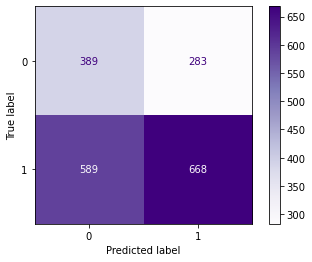

In [17]:
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)

cm=confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=clf.classes_)
disp.plot(cmap='Purples') 


In [18]:
spec= round(tn/(tn+fp), 4)
acc= round(metrics.accuracy_score(y_test, y_pred), 4)
prec= round(metrics.precision_score(y_test, y_pred), 4)
rec= round(metrics.recall_score(y_test, y_pred), 4)
f1= round(metrics.f1_score(y_test, y_pred), 4)
print ('Specificity:',spec)
print ('Accuracy:',acc)
print ('Precision:',prec)
print ('Recall or Sensitivity:',rec)
print ('F1 Score:',f1)

Specificity: 0.5789
Accuracy: 0.548
Precision: 0.7024
Recall or Sensitivity: 0.5314
F1 Score: 0.6051


In [19]:
model='knn2pca'
depdelay='no'

cur.execute("INSERT OR REPLACE INTO s13_models(model,dep_delay,Specificity, Accuracy, Precision, Recall, f1_score) VALUES(?,?,?,?,?,?,?)",(model,depdelay,spec,acc,prec,rec,f1))
conn.commit()




##### Decision Tree

In [24]:
clf = DecisionTreeClassifier(criterion="gini", max_depth=4, random_state=42)
scores=cross_val_score(clf, X_train, y_train, cv=StratifiedKFold(n_splits=5), scoring='accuracy').mean()
print('Accuracy Score: %.4f' % scores)

Accuracy Score: 0.5804


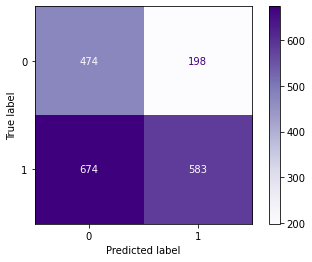

In [25]:
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

cm=confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=clf.classes_)
disp.plot(cmap='Purples') 

In [26]:
spec= round(tn/(tn+fp), 4)
acc= round(metrics.accuracy_score(y_test, y_pred), 4)
prec= round(metrics.precision_score(y_test, y_pred), 4)
rec= round(metrics.recall_score(y_test, y_pred), 4)
f1= round(metrics.f1_score(y_test, y_pred), 4)
print ('Specificity:',spec)
print ('Accuracy:',acc)
print ('Precision:',prec)
print ('Recall or Sensitivity:',rec)
print ('F1 Score:',f1)

Specificity: 0.7054
Accuracy: 0.548
Precision: 0.7465
Recall or Sensitivity: 0.4638
F1 Score: 0.5721


In [27]:
model='dt2pca'
depdelay='no'

cur.execute("INSERT OR REPLACE INTO s13_models(model,dep_delay,Specificity, Accuracy, Precision, Recall, f1_score) VALUES(?,?,?,?,?,?,?)",(model,depdelay,spec,acc,prec,rec,f1))
conn.commit()




##### neural network MLPClassifier

In [28]:
mlp = MLPClassifier(hidden_layer_sizes=(20, 10, 5), max_iter=50, activation = 'relu',solver='adam',random_state=42)
score=cross_val_score(mlp, X_train, y_train, cv=StratifiedKFold(n_splits=10), scoring='accuracy').mean()
print('Accuracy Score: %.4f' % score)

Accuracy Score: 0.5873


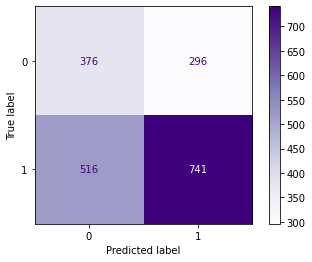

In [29]:
mlp.fit(X_train, y_train)
y_pred = mlp.predict(X_test)

cm=confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=clf.classes_)
disp.plot(cmap='Purples') 

In [30]:
spec= round(tn/(tn+fp), 4)
acc= round(metrics.accuracy_score(y_test, y_pred), 4)
prec= round(metrics.precision_score(y_test, y_pred), 4)
rec= round(metrics.recall_score(y_test, y_pred), 4)
f1= round(metrics.f1_score(y_test, y_pred), 4)
print ('Specificity:',spec)
print ('Accuracy:',acc)
print ('Precision:',prec)
print ('Recall or Sensitivity:',rec)
print ('F1 Score:',f1)

Specificity: 0.5595
Accuracy: 0.5791
Precision: 0.7146
Recall or Sensitivity: 0.5895
F1 Score: 0.646


In [31]:
model='nn2pca'
depdelay='no'

cur.execute("INSERT OR REPLACE INTO s13_models(model,dep_delay,Specificity, Accuracy, Precision, Recall, f1_score) VALUES(?,?,?,?,?,?,?)",(model,depdelay,spec,acc,prec,rec,f1))
conn.commit()

##### Gaussian Naive Bayes

In [32]:
clf = GaussianNB()
score=cross_val_score(clf, X_train, y_train, cv=StratifiedKFold(n_splits=5), scoring='accuracy').mean()
print('Accuracy Score: %.4f' % score)

Accuracy Score: 0.5903


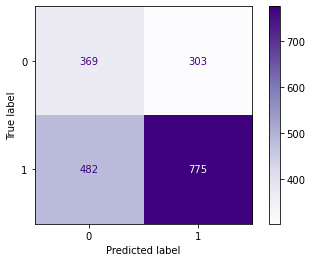

In [33]:
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

cm=confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=clf.classes_)
disp.plot(cmap='Purples') 

In [34]:
spec= round(tn/(tn+fp), 4)
acc= round(metrics.accuracy_score(y_test, y_pred), 4)
prec= round(metrics.precision_score(y_test, y_pred), 4)
rec= round(metrics.recall_score(y_test, y_pred), 4)
f1= round(metrics.f1_score(y_test, y_pred), 4)
print ('Specificity:',spec)
print ('Accuracy:',acc)
print ('Precision:',prec)
print ('Recall or Sensitivity:',rec)
print ('F1 Score:',f1)

Specificity: 0.5491
Accuracy: 0.5931
Precision: 0.7189
Recall or Sensitivity: 0.6165
F1 Score: 0.6638


In [35]:
model='nb2pca'
depdelay='no'

cur.execute("INSERT OR REPLACE INTO s13_models(model,dep_delay,Specificity, Accuracy, Precision, Recall, f1_score) VALUES(?,?,?,?,?,?,?)",(model,depdelay,spec,acc,prec,rec,f1))
conn.commit()



##### Ada Boost Classifier

In [36]:
ada = AdaBoostClassifier(n_estimators=12, random_state=42,algorithm='SAMME')
score=cross_val_score(ada, X_train, y_train, cv=StratifiedKFold(n_splits=5), scoring='accuracy').mean()
print('Accuracy Score: %.4f' % score)

Accuracy Score: 0.5858


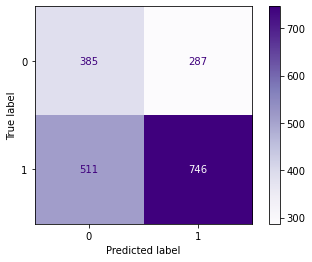

In [37]:
ada.fit(X_train, y_train)
y_pred = ada.predict(X_test)

cm=confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Purples') 

In [38]:
spec= round(tn/(tn+fp), 4)
acc= round(metrics.accuracy_score(y_test, y_pred), 4)
prec= round(metrics.precision_score(y_test, y_pred), 4)
rec= round(metrics.recall_score(y_test, y_pred), 4)
f1= round(metrics.f1_score(y_test, y_pred), 4)
print ('Specificity:',spec)
print ('Accuracy:',acc)
print ('Precision:',prec)
print ('Recall or Sensitivity:',rec)
print ('F1 Score:',f1)

Specificity: 0.5729
Accuracy: 0.5863
Precision: 0.7222
Recall or Sensitivity: 0.5935
F1 Score: 0.6515


In [39]:
model='ada2pca'
depdelay='no'

cur.execute("INSERT OR REPLACE INTO s13_models(model,dep_delay,Specificity, Accuracy, Precision, Recall, f1_score) VALUES(?,?,?,?,?,?,?)",(model,depdelay,spec,acc,prec,rec,f1))
conn.commit()

##### Gaussian Process Classifier

In [40]:
gpc = GaussianProcessClassifier(kernel=1*RBF(1.0))
score=cross_val_score(gpc, X_train, y_train, cv=StratifiedKFold(n_splits=5), scoring='accuracy').mean()
print('Accuracy Score: %.4f' % score)

Accuracy Score: 0.5923


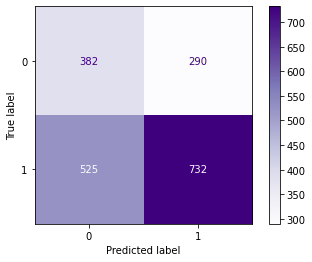

In [41]:
gpc.fit(X_train, y_train)
y_pred = gpc.predict(X_test)

cm=confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Purples') 

In [42]:
spec= round(tn/(tn+fp), 4)
acc= round(metrics.accuracy_score(y_test, y_pred), 4)
prec= round(metrics.precision_score(y_test, y_pred), 4)
rec= round(metrics.recall_score(y_test, y_pred), 4)
f1= round(metrics.f1_score(y_test, y_pred), 4)
print ('Specificity:',spec)
print ('Accuracy:',acc)
print ('Precision:',prec)
print ('Recall or Sensitivity:',rec)
print ('F1 Score:',f1)

Specificity: 0.5685
Accuracy: 0.5775
Precision: 0.7162
Recall or Sensitivity: 0.5823
F1 Score: 0.6424


In [43]:
model='gp2pca'
depdelay='no'

cur.execute("INSERT OR REPLACE INTO s13_models(model,dep_delay,Specificity, Accuracy, Precision, Recall, f1_score) VALUES(?,?,?,?,?,?,?)",(model,depdelay,spec,acc,prec,rec,f1))
conn.commit()




##### XGboost

In [10]:
xg_reg = xgb.XGBClassifier(objective="reg:squarederror", booster="gblinear", colsample_bytree = 0.3, learning_rate = 0.1,
                           max_depth = 5, alpha = 10, n_estimators = 1000, verbosity = 0)
scores = cross_val_score(xg_reg, X_train, y_train, cv=StratifiedKFold(n_splits=5), scoring='accuracy').mean()
scores

0.49975216852540266

In [11]:
xg_reg.fit(X_train,y_train)
preds = xg_reg.predict(X_test)

acc = metrics.accuracy_score(y_test, preds)
print("Accuracy: %f" % (acc))

Accuracy: 0.349404


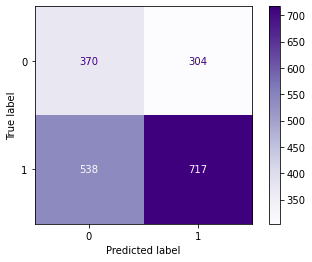

In [12]:
xg_reg.fit(X_train, y_train)
y_pred = xg_reg.predict(X_test)

cm=confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Purples') 

In [13]:
spec= round(tn/(tn+fp), 4)
acc= round(metrics.accuracy_score(y_test, y_pred), 4)
prec= round(metrics.precision_score(y_test, y_pred), 4)
rec= round(metrics.recall_score(y_test, y_pred), 4)
f1= round(metrics.f1_score(y_test, y_pred), 4)
print ('Specificity:',spec)
print ('Accuracy:',acc)
print ('Precision:',prec)
print ('Recall or Sensitivity:',rec)
print ('F1 Score:',f1)

Specificity: 0.549
Accuracy: 0.5635
Precision: 0.7023
Recall or Sensitivity: 0.5713
F1 Score: 0.6301


In [14]:
model='xgb2pca'
depdelay='no'

cur.execute("INSERT OR REPLACE INTO s13_models(model,dep_delay,Specificity, Accuracy, Precision, Recall, f1_score) VALUES(?,?,?,?,?,?,?)",(model,depdelay,spec,acc,prec,rec,f1))
conn.commit()